# 第七章 程序辅助 LLM

<div class="toc">
 <ul class="toc-item">
     <li><span><a href="#一、引言" data-toc-modified-id="一、引言">一、引言</a></span></li>
     <li>
         <span><a href="#二、程序辅助 LLM" data-toc-modified-id="二、程序辅助 LLM">二、程序辅助 LLM</a></span>
         <ul class="toc-item">
             <li><span><a href="##2.1 数学问题" data-toc-modified-id="2.1 数学问题">2.1 数学问题</a></span></li>
             <li><span><a href="##2.2 颜色物体问题" data-toc-modified-id="2.2 颜色物体问题">2.2 颜色物体问题</a></span></li>
             </ul>
         </li>
     <li><span><a href="#三、总结与讨论" data-toc-modified-id="三、总结与讨论">三、总结与讨论</a></span></li>
     </ul>
</div>

## 一、引言
***

最近，大语言模型（Large Language Models, LLMs）在众多任务中取得了显著的成功，这些任务包括使用少样本提示（Few-shot Prompting）进行常识推理、数学推理和符号推理。此外，通过要求 LLM 明确生成推理步骤，常用的思维链（COT）方法能为模型提供达到最终答案所需的显式中间步骤。然而，尽管 LLM 能够将自然语言问题分解为步骤并执行简单的算术运算，但在处理复杂的算术问题时，其性能可能会显著下降。

Luyu Gao 等人在 [ICML 2023 - PAL: Program-aided Language Models](https://icml.cc/virtual/2023/poster/23864) 发表的一篇论文提出了 **PAL: 程序辅助的语言模型。**

这项研究提出了一种新的自然语言推理方法，**它使用程序作为中间推理步骤**（而不是自然语言的思维链），将求解和计算的任务外包给一个外部的 Python 解释器，而不是完全依赖语言模型自身。

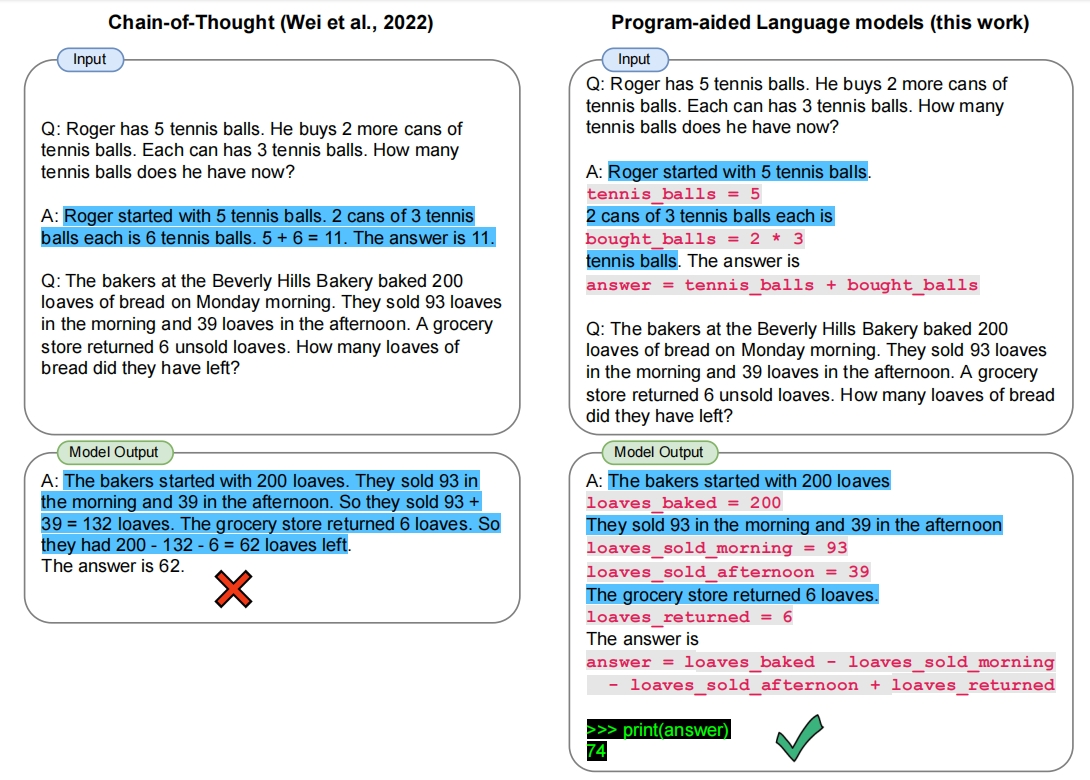

实验结果表明：研究者在 13 个**数学、符号和算法推理**任务上验证了 PAL 的有效性，他们发现 PAL 在所有任务上都超越了使用流行的 “思维链” 方法的更大的语言模型，如 PaLM-540B，并在所有任务上都达到了新的最高准确率。

研究者对 PAL 的优势和局限性进行了分析，他们发现 PAL 可以与具有良好编码能力的不同代码语言模型以及非代码语言模型协同工作。他们还发现，**使用有意义的变量名和自然语言注释可以提升 PAL 的性能**，而且生成的 Python 代码都是语法正确的，很少引发运行时异常。神经 LLM 和符号解释器之间的无缝协同是通向通用且稳健的 AI 推理器的重要一步。

本章将详细介绍程序辅助 LLM。我们将深入阐述关键原理，并提供实际的代码示例，以帮助读者全面理解并掌握程序辅助 LLM 的关键原理和实际应用。阅读本章后，读者将能够更专业、准确地理解和应用程序辅助 LLM。

## 二、程序辅助 LLM
***

注意：我使用的测试环境是 Anaconda + Python 3.8.10。Python 的版本要求 Python 3.7+。

开始实验之前，我们需要安装好本次实验所需的第三方依赖库：

- `openai`：OpenAI Python 库提供了一个便捷的途径，让任何 Python 3.7+ 应用程序可以访问 OpenAI REST API。您可以通过运行以下命令来安装：`pip install openai==1.10.0`。

- `langchain`：LangChain 是一个基于语言模型开发应用程序的框架。您可以通过运行以下命令来安装：`pip install langchain==0.1.5`。此外，可能还需要安装 LangChain 的一些扩展：`pip install -U langchain-openai`、`pip install langchain-experimental==0.0.50`


导入此次实验所需的依赖库

In [1]:
import os
import langchain
from langchain_experimental.pal_chain import PALChain
from langchain_openai import ChatOpenAI
from langchain.chains.llm import LLMChain


# 从环境变量中获取 OpenAI API Key 或者直接赋值
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
OPENAI_API_KEY = "sk-...你的 OpenAI API Key"

# 如果您使用的是官方 API，就直接用 https://api.openai.com/v1 就行。
BASE_URL = "https://api.openai.com/v1"
# 如果您使用的不是官方 API，而是通过代理进行请求，请设置您的代理 URL。
# BASE_URL = "https://api.xxx.../v1"

- `ChatOpenAI(...)`: 这行代码初始化了一个 `ChatOpenAI` 的对象，即创建一个与 OpenAI GPT-3.5 Turbo 模型进行交互的客户端。`ChatOpenAI` 是 LangChain 库中定义的一个类。

- `temperature=0.20`: 温度设置用于控制生成文本的随机性。温度越低，生成的文本越确定性（即趋向于最有可能的输出）。在这里，设置为 0.20 意味着生成的文本相对比较确定性，不太随机。

- `model_name="gpt-3.5-turbo-0125"`: 指定使用的模型名称。这里指定使用 GPT-3.5 Turbo 0125 版模型。

- `max_tokens=1024`: 设置生成文本时最多使用的 tokens 数量。在这里，限制为 1024 个 tokens。

- `max_retries=3`：如果 API 请求失败，最多尝试重新发送请求 3 次。

In [2]:
llm = ChatOpenAI(temperature=0.20, model_name="gpt-3.5-turbo-0125", max_tokens=1024,
                 openai_api_key=OPENAI_API_KEY, openai_api_base=BASE_URL, max_retries=3
                )

**PAL 的工作原理：**

- PAL 使用大语言模型（LLM）读取自然语言问题，并生成程序作为中间推理步骤，但将解决步骤外包给 Python 解释器。

- 在 PAL 中，我们将自然语言问题分解为可执行的步骤，其中 LLM 仅用于学习任务，而问题解决则外包给 Python 解释器。这种方法与思维链提示不同，因为它不是通过自由形式的文本来获取解决方案，而是将解决步骤转移到类似 Python 解释器的程序执行环境中。例如，对于给定的自然语言问题 $x$，我们生成推理过程 $t$，其中包含交错的自然语言（NL）和编程语言（PL）语句。由于我们将解决方案的步骤外包给 Python 解释器，所以我们不会在提示中给出最终答案。

- 在所有这些自然语言推理任务中，使用 LLM 生成代码并利用 Python 解释器进行推理，可以得到比更大规模模型更准确的结果。这种神经 LLM 和符号解释器之间的协同作用在 BIG-Bench Hard 和其他基准测试的 13 项数学、符号和算法推理任务中得到了体现。


### 2.1 数学问题

In [3]:
pal_chain = PALChain.from_math_prompt(llm, verbose=True)

prompt_Chinese = """罗杰有 5 个网球。他又买了 2 罐网球。\
每罐有 3 个网球。他现在有多少个网球？
"""
print(f"中文 Prompt：{prompt_Chinese}")
pal_chain.invoke(prompt_Chinese)

中文 Prompt：罗杰有 5 个网球。他又买了 2 罐网球。每罐有 3 个网球。他现在有多少个网球？



> Entering new PALChain chain...


Python REPL can execute arbitrary code. Use with caution.


def solution():
    """罗杰有 5 个网球。他又买了 2 罐网球。每罐有 3 个网球。他现在有多少个网球？"""
    网球_initial = 5
    罐数 = 2
    每罐网球数 = 3
    网球总数 = 网球_initial + (罐数 * 每罐网球数)
    result = 网球总数
    return result

> Finished chain.


{'question': '罗杰有 5 个网球。他又买了 2 罐网球。每罐有 3 个网球。他现在有多少个网球？\n', 'result': '11'}

In [4]:
pal_chain = PALChain.from_math_prompt(llm, verbose=True)


prompt_English = """Roger has 5 tennis balls. \
He buys 2 more cans of tennis balls. \
Each can has 3 tennis balls. \
How many tennis balls does he have now?
"""
print(f"英文 Prompt：{prompt_English}")
pal_chain.invoke(prompt_English)

英文 Prompt：Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?



> Entering new PALChain chain...
def solution():
    """Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?"""
    tennis_balls_initial = 5
    cans_bought = 2
    balls_per_can = 3
    total_balls = tennis_balls_initial + (cans_bought * balls_per_can)
    result = total_balls
    return result

> Finished chain.


{'question': 'Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?\n',
 'result': '11'}

在 `LangChain` 的 `langchain_experimental/pal_chain/math_prompt.py` 源码中，我们可以看到一个专为数学问题设计的 `Prompt 模板`。其主要目的是通过提供示例来促进上下文学习。如下图所示：

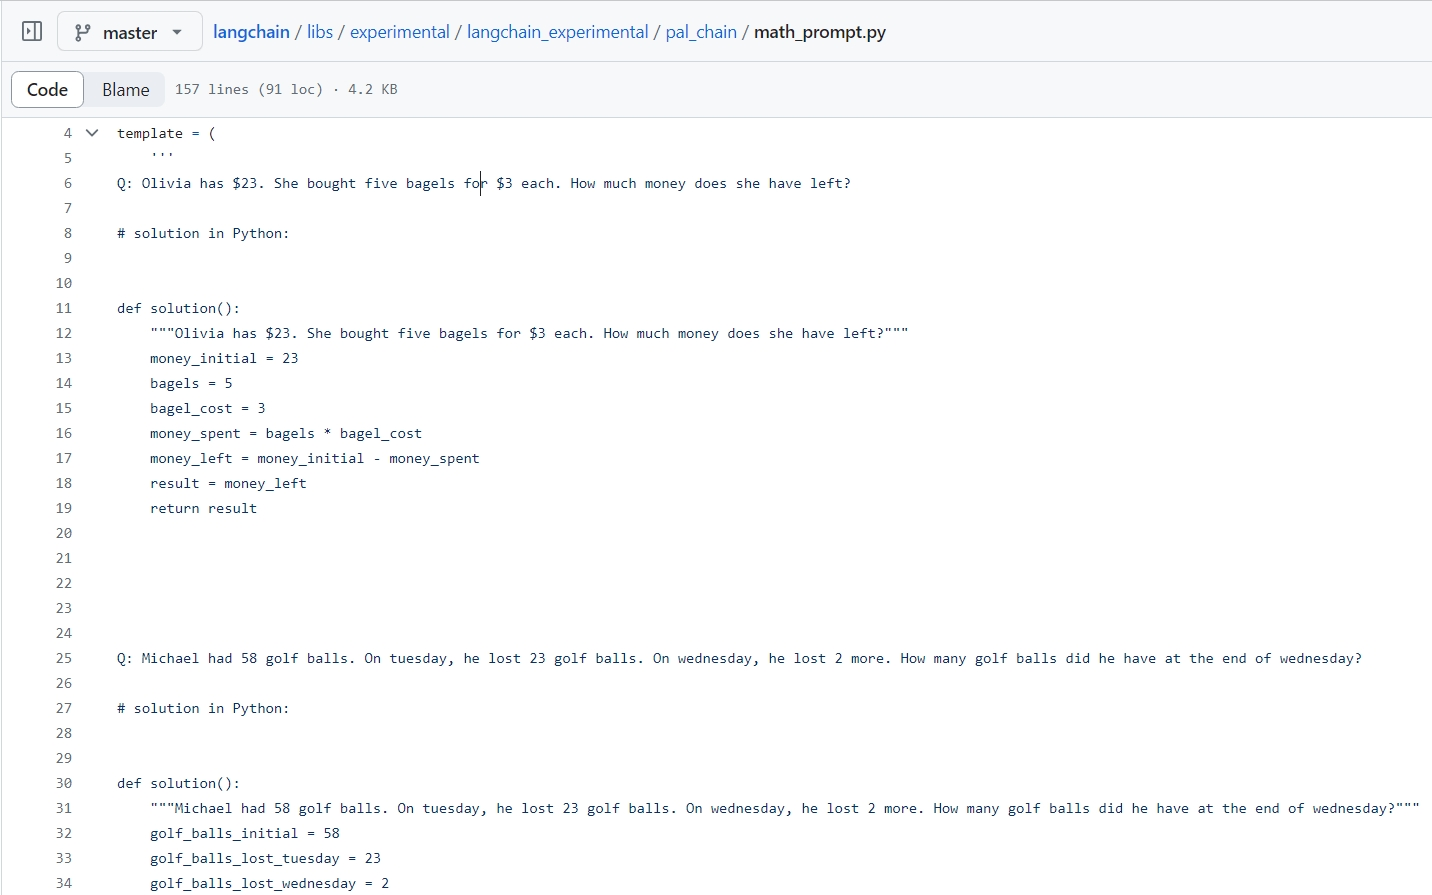

Github 链接：https://github.com/langchain-ai/langchain/blob/master/libs/experimental/langchain_experimental/pal_chain/math_prompt.py


### 2.2 颜色物体问题

解答关于表面有色物体的问题。这项任务需要追踪每个物体的相对位置、绝对位置以及颜色。

In [5]:
pal_chain = PALChain.from_colored_object_prompt(llm, verbose=True)

prompt_Chinese = """在桌子上，你看到一堆物品排列成一排：\
紫色回形针、粉色压力球、棕色钥匙扣、绿色抓握式手机充电器、淡紫色小飞虫和酒红色钢笔。\
压力球右边的物体是什么颜色的？
"""
print(f"中文 Prompt：{prompt_Chinese}")
pal_chain.invoke(prompt_Chinese)

中文 Prompt：在桌子上，你看到一堆物品排列成一排：紫色回形针、粉色压力球、棕色钥匙扣、绿色抓握式手机充电器、淡紫色小飞虫和酒红色钢笔。压力球右边的物体是什么颜色的？



> Entering new PALChain chain...
# 将物品放入一个列表中记录顺序
objects = []
objects += [('回形针', '紫色')] * 1
objects += [('压力球', '粉色')] * 1
objects += [('钥匙扣', '棕色')] * 1
objects += [('手机充电器', '绿色')] * 1
objects += [('小飞虫', '淡紫色')] * 1
objects += [('钢笔', '酒红色')] * 1

# 找到压力球的索引
stress_ball_idx = None
for i, object in enumerate(objects):
    if object[0] == '压力球':
        stress_ball_idx = i
        break

# 找到压力球右边的物体
right_object = objects[i+1]

# 检查右边物体的颜色
right_object_color = right_object[1]
answer = right_object_color

> Finished chain.


{'question': '在桌子上，你看到一堆物品排列成一排：紫色回形针、粉色压力球、棕色钥匙扣、绿色抓握式手机充电器、淡紫色小飞虫和酒红色钢笔。压力球右边的物体是什么颜色的？\n',
 'result': '棕色'}

In [6]:
pal_chain = PALChain.from_colored_object_prompt(llm, verbose=True)

prompt_English = """On the table, you see a bunch of objects arranged in a row: \
a purple paperclip, a pink stress ball, a brown keychain, \
a green scrunchiephone charger, a mauve fidget spinner, and a burgundy pen. \
What is the color of the object directly to the right of the stress ball?
"""
print(f"英文 Prompt：{prompt_English}")
pal_chain.invoke(prompt_English)

英文 Prompt：On the table, you see a bunch of objects arranged in a row: a purple paperclip, a pink stress ball, a brown keychain, a green scrunchiephone charger, a mauve fidget spinner, and a burgundy pen. What is the color of the object directly to the right of the stress ball?



> Entering new PALChain chain...
# Put objects into a list to record ordering
objects = []
objects += [('paperclip', 'purple')] * 1
objects += [('stress ball', 'pink')] * 1
objects += [('keychain', 'brown')] * 1
objects += [('scrunchiephone charger', 'green')] * 1
objects += [('fidget spinner', 'mauve')] * 1
objects += [('pen', 'burgundy')] * 1

# Find the index of the stress ball
stress_ball_idx = None
for i, object in enumerate(objects):
    if object[0] == 'stress ball':
        stress_ball_idx = i
        break

# Find the directly right object
direct_right = objects[i+1]

# Check the directly right object's color
direct_right_color = direct_right[1]
answer = direct_right_color

> Finished chain.


{'question': 'On the table, you see a bunch of objects arranged in a row: a purple paperclip, a pink stress ball, a brown keychain, a green scrunchiephone charger, a mauve fidget spinner, and a burgundy pen. What is the color of the object directly to the right of the stress ball?\n',
 'result': 'brown'}

在 `LangChain` 的 `langchain_experimental/pal_chain/colored_object_prompt.py` 源码中，我们可以看到一个专为颜色物体问题设计的 `Prompt 模板`。其主要目的是通过提供示例来促进上下文学习。如下图所示：

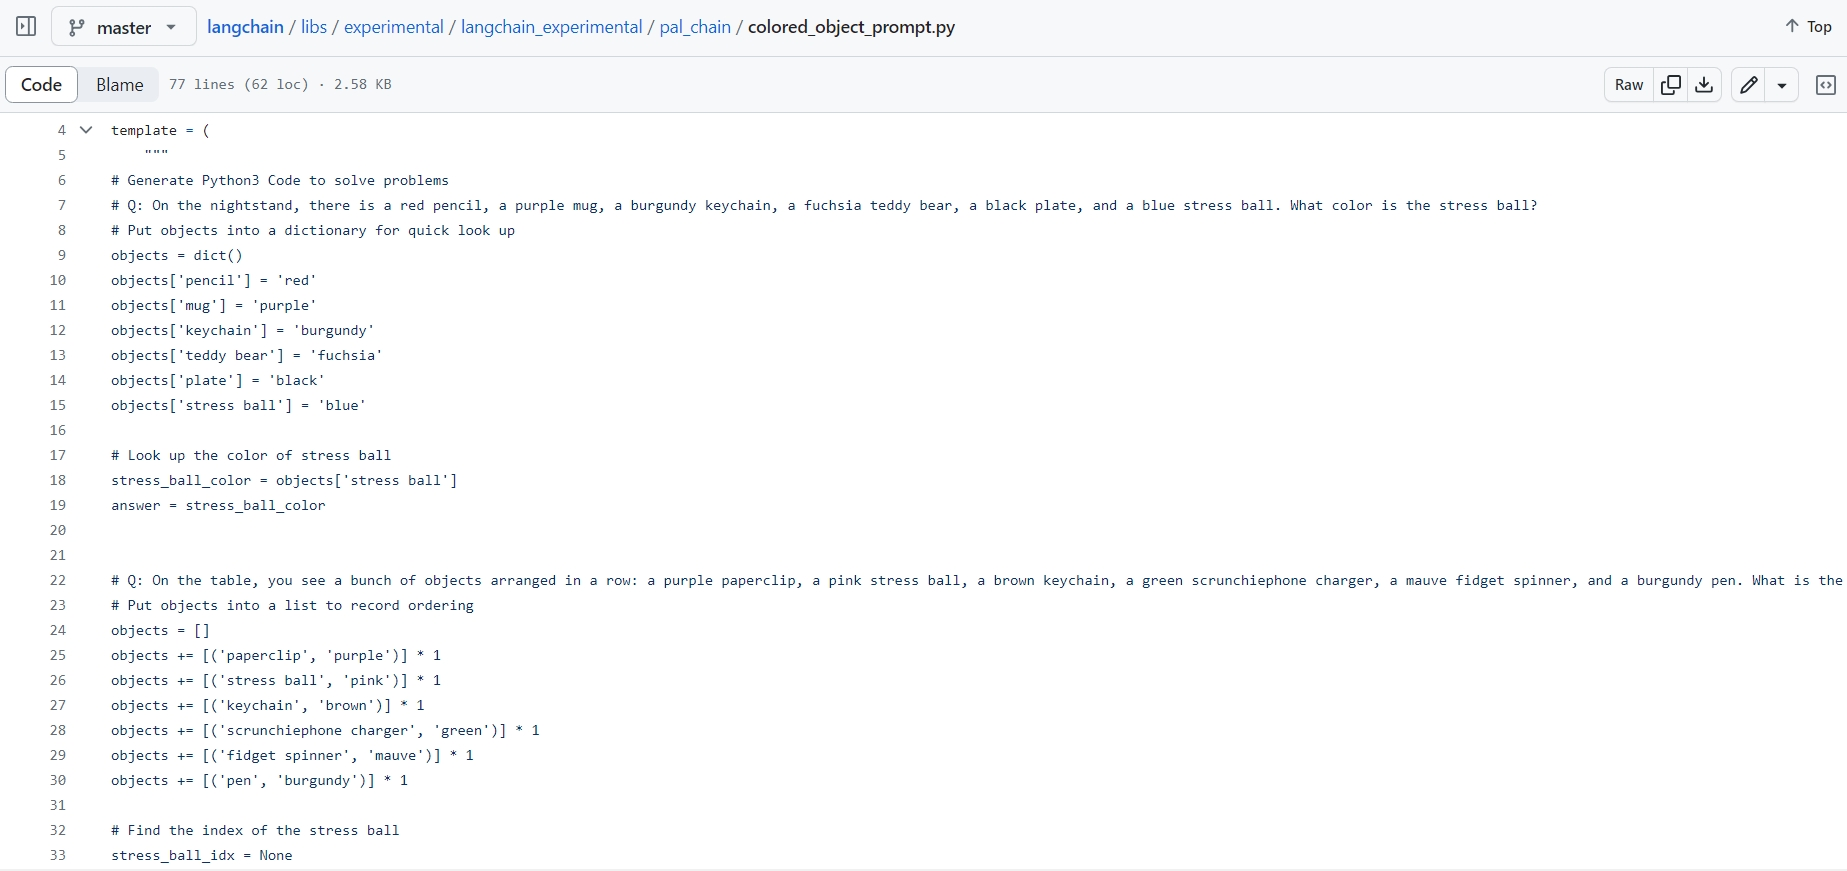

Github 链接：https://github.com/langchain-ai/langchain/blob/master/libs/experimental/langchain_experimental/pal_chain/colored_object_prompt.py


## 三、总结与讨论
***

PAL 的优点主要包括：
- 有效性：在 13 个数学、符号和算法推理任务上，使用大语言模型生成代码并使用 Python 解释器进行推理，比使用更大的模型更准确。例如，使用 CODEX 的 PAL 在 GSM8K 数学字问题基准测试中实现了最先进的少样本精度，超过了使用思维链的 PaLM-540B 绝对 15％ top1。

- 协同作用：大语言模型和符号解释器之间的协同作用，涵盖了 BIG-Bench Hard 和其他基准测试中的 13 项数学、符号和算法推理任务。这种无缝协同被认为是通向通用和稳健 AI 推理器的重要一步。

- **灵活性**：PAL 可以与不同强度的语言模型协同工作，也可以与非代码语言模型协同工作，只要它们具有足够好的编码能力。

PAL 其实不算通用，目前存在一些局限性：
- PAL 依赖于大语言模型生成正确的程序，如果程序有语法错误或逻辑错误，那么解释器无法执行或得到错误的结果。

- PAL 目前只适用于可以用 Python 代码表示的推理任务，对于一些需要更复杂或更专业的语言或工具的任务，这个方法可能并不能直接应用或效果不佳。

- **PAL 需要为每个任务定制合适的程序提示过程**（上下文学习），这可能需要一定的编程知识和经验，而且不同的提示可能会影响语言模型的生成质量和效率。

LLM 代码生成质量高的原因：
- 用于 LLM 训练的代码数据质量要比文本质量更高，自然文本数据中价值观冲突太多。

- 形式语言中「语法和语义的距离」比高度灵活的自然语言要低。

- 自回归 LLM 对编码很有帮助。

**虽然 PAL 存在局限性，但将生成程序作为推理步骤的方法仍值得深入研究，以解决更复杂的问题，这为其广泛应用提供了可能性。**


📚 主要参考资料：
- ICML 2023 - PAL: Program-aided Language Models，https://icml.cc/virtual/2023/poster/23864

- LangChain langchain_experimental pal_chain 源码，https://github.com/langchain-ai/langchain/tree/master/libs/experimental/langchain_experimental/pal_chain
